In [118]:
import networkx as nx 
import numpy as np
import pandas as pd
import glob
import matplotlib
import os
%matplotlib inline

In [119]:
H.edges(data=True)

OutEdgeDataView([(5, 6, {'time': 15.0, 'ros': 6.644310146240075}), (5, 3, {'time': 68.0, 'ros': 3.1912779869040797}), (5, 9, {'time': 117.0, 'ros': 1.4994814627980455}), (5, 2, {'time': 140.0, 'ros': 1.045980408461427}), (5, 8, {'time': 178.0, 'ros': 0.7445362529713141}), (5, 4, {'time': 248.0, 'ros': 0.5768646411923818}), (5, 1, {'time': 270.0, 'ros': 0.7263987467509242}), (5, 7, {'time': 299.0, 'ros': 0.6290266677044886})])

In [120]:
#Utility, Volume, DemandArray = ReadForest(InFolder, 1)
heuristic = 6
N = 40
M = 40
NCells = N * M
path_messages = "C:/Users/chile/Desktop/FPVTest_40x40_4Oct/Messages"#"C:/Users/chile/Desktop/FPVTest_40x40_4Oct/Messages"
G = []

# Read txt files with messages (array with name of files) 
msgFiles = glob.glob(path_messages + '/*.txt')
nsim = len(msgFiles)

print("We have", nsim, "message files, generating the graphs...")

# Keep FPV for each simulation 
FPVMatrices = []

# Heuristic 6: New FPV heuristic
if heuristic == 6:
    nodes = range(1, NCells + 1)
    
    # We build a Digraph (directed graph, general graph for the instance)
    G = nx.DiGraph()
    
    # We add nodes to the list
    G.add_nodes_from(nodes)

    # Populate nodes fields for the general graph (no edges)
    for i in G.nodes:
        G.node[i]['price'] = 1
        G.node[i]['vol'] = 1
        G.node[i]['cost'] = 0
        G.node[i]['profit'] = (G.node[i]['price'] - G.node[i]['cost']) * G.node[i]['vol']
        G.node[i]['fpv'] = 0

    # For each simulation, we create a graph with edges containing time and ROS at the moment of the message
    for k in range(1, nsim + 1):
        H = nx.read_edgelist(path=path_messages + '/MessagesFile' + str(k) + '.txt',
                             create_using=nx.DiGraph(),
                             nodetype=int,
                             data=[('time', float), ('ros', float)])
        
        # Assign the profit from the main graph
        for i in H.nodes:
            H.node[i]['profit'] = G.node[i]['profit']
        
        # Tree dictionary
        Tree = dict()
        
        # Aux FPV Matrix for individual FPV values
        AuxFPVMatrix = np.zeros([N,M])
        
        # For each node inside the simulation graphs, calculate the FPV based on the descendants
        for i in H.nodes:
            Tree[i] = nx.subgraph(H, {i} | nx.descendants(H, i))
            H.node[i]['fpv'] = sum([H.node[j]['profit'] for j in Tree[i].nodes])
            G.node[i]['fpv'] = G.node[i]['fpv'] + H.node[i]['fpv']
            AuxFPVMatrix[(i-1)//M, i - M * ((i-1)//M) - 1 ] = H.nodes[i]['fpv']
                
        # Append the instance FPV matrix 
        FPVMatrices.append(AuxFPVMatrix)
        
        # Add edges to G including the frequency of the message from one cell to another
        for e in H.edges():
            #print("e:",e, e[0],e[1])
            if G.has_edge(*e):
                G.get_edge_data(e[0],e[1])["weight"] += 1
            else:
                G.add_weighted_edges_from([(*e,1.)])

# Check FPVMatrices
print(FPVMatrices)
        
# Total / Average FPV Matrix
FPVMatrix = np.zeros([N,M])
for i in G.nodes():
    #print(i, (i-1)//40, i - 40 * ((i-1)//40) - 1 )
    FPVMatrix[(i-1)//M, i - M * ((i-1)//M) - 1 ] = G.nodes[i]['fpv']
print(FPVMatrix)
np.savetxt("C:/Users/chile/Desktop/Global_FPV_Matrix.csv", FPVMatrix, delimiter=" ", fmt="%.f")
np.savetxt("C:/Users/chile/Desktop/Global_FPV_Matrix_Normalized.csv", 
           FPVMatrix/np.max(FPVMatrix), delimiter=" ", fmt="%.3f")
        

We have 1014 message files, generating the graphs...
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [2., 2., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0.

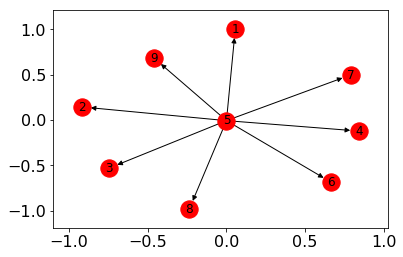

In [57]:
nx.drawing.nx_pylab.draw_networkx(H)

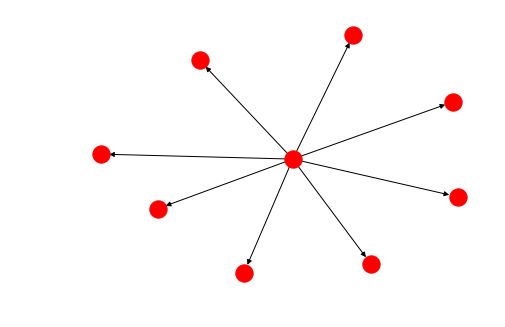

In [58]:
nx.draw(H)

In [122]:
G.edges(data=True)

OutEdgeDataView([(41, 42, {'weight': 14.0}), (42, 83, {'weight': 8.0}), (53, 13, {'weight': 355.0}), (77, 38, {'weight': 3.0}), (78, 39, {'weight': 1.0}), (79, 40, {'weight': 2.0}), (79, 39, {'weight': 2.0}), (80, 40, {'weight': 4.0}), (81, 41, {'weight': 141.0}), (82, 42, {'weight': 127.0}), (84, 45, {'weight': 157.0}), (87, 46, {'weight': 286.0}), (91, 51, {'weight': 375.0}), (92, 52, {'weight': 373.0}), (92, 51, {'weight': 5.0}), (92, 53, {'weight': 1.0}), (93, 53, {'weight': 363.0}), (93, 54, {'weight': 12.0}), (94, 54, {'weight': 335.0}), (117, 78, {'weight': 5.0}), (117, 77, {'weight': 4.0}), (119, 79, {'weight': 6.0}), (119, 80, {'weight': 19.0}), (120, 80, {'weight': 10.0}), (121, 81, {'weight': 150.0}), (122, 82, {'weight': 146.0}), (123, 83, {'weight': 148.0}), (124, 84, {'weight': 184.0}), (127, 87, {'weight': 254.0}), (128, 88, {'weight': 281.0}), (128, 87, {'weight': 121.0}), (129, 89, {'weight': 184.0}), (129, 88, {'weight': 43.0}), (130, 90, {'weight': 302.0}), (130, 89,

In [123]:
G.nodes(data=True)

NodeDataView({1: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 2: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 3: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 4: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 5: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 6: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 7: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 8: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 9: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 10: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 11: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 12: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 13: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 355}, 14: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 15: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 16: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0}, 1

In [154]:
# Edges
A = nx.to_numpy_matrix(G)

print("---- Edges as message frequencies ----")
print("Matrix A shape:", A.shape)
print("Max frequency:", np.max(A),
      "\nMin frequency:", np.min(A),
      "\nMean frequency:", np.round(np.mean(A),3),
      "\nMean freq no 0s:", np.round(np.mean(A[A!=0]), 3))
np.savetxt("C:/Users/chile/Desktop/Edges_Frequency_Hit_Matrix.csv", A, delimiter=" ", fmt="%.f")

# Nodes (compare with FPVMatrix)
print("\n---- Checking nodes ----")
B = nx.attr_matrix(G, node_attr="fpv")
print("From graph:", np.max(B[1]))
print("From FPV matrix:", np.max(FPVMatrix))



---- Edges as message frequencies ----
Matrix A shape: (1600, 1600)
Max frequency: 942.0 
Min frequency: 0.0 
Mean frequency: 0.187 
Mean freq no 0s: 186.05

---- Checking nodes ----
From graph: 90267
From FPV matrix: 90267.0


In [192]:
print("MAX FPV in:", np.argmax(FPVMatrix/np.max(FPVMatrix)), "Value:", np.max(FPVMatrix/np.max(FPVMatrix)))
print("MAX FPV * Freq in:", np.argmax(FPVMatrix/np.max(FPVMatrix) *OutFireMatrix/np.max(OutFireMatrix)), 
      "Value:", np.max(FPVMatrix/np.max(FPVMatrix) * OutFireMatrix/np.max(OutFireMatrix)))

MAX FPV in: 1011 Value: 1.0
MAX FPV * Freq in: 1011 Value: 1.0


In [204]:
np.flip(np.sort(FPVMatrix.flatten()), axis=0)

array([90267., 83075., 81549., ...,     0.,     0.,     0.])

In [209]:
np.flip(np.sort((FPVMatrix * OutFireMatrix/np.max(OutFireMatrix)).flatten()), axis=0)

array([90267.        , 81257.2509311 , 72285.51955307, ...,
           0.        ,     0.        ,     0.        ])

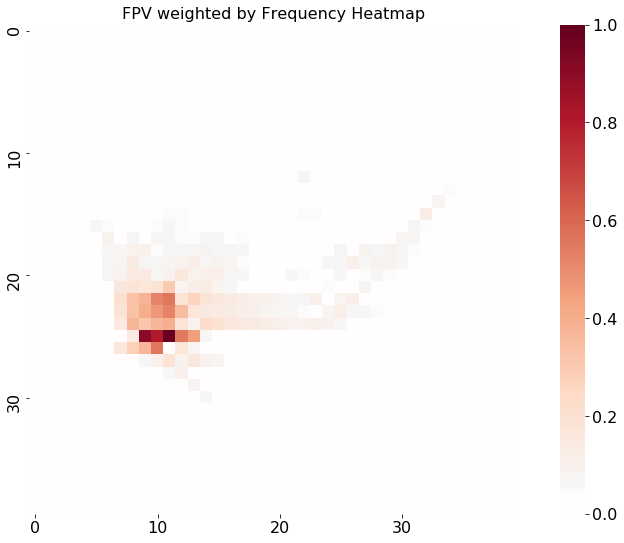

In [212]:
# Global FPV by frequency
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
        
# Figure size
plt.figure(figsize = (15, 9)) 

# Font sizes
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 18

# axes
ax = plt.subplot(111)                    
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Title and labels
plt.title("FPV weighted by Frequency Heatmap")

# Modify existing map to have white values
cmap = cm.get_cmap('RdBu_r')
lower = plt.cm.seismic(np.ones(100)*0.50)
upper = cmap(np.linspace(1-0.5, 1, 90))
colors = np.vstack((lower, upper))
tmap = matplotlib.colors.LinearSegmentedColormap.from_list('terrain_map_white', colors)
        
        
ax = sns.heatmap(FPVMatrix/np.max(FPVMatrix) * OutFireMatrix/np.max(OutFireMatrix), 
                 center=0.0, xticklabels=10, yticklabels=10, 
                 square=True, cmap=tmap, 
                 vmin=0, vmax=np.max((FPVMatrix/np.max(FPVMatrix) * OutFireMatrix/np.max(OutFireMatrix)))) 

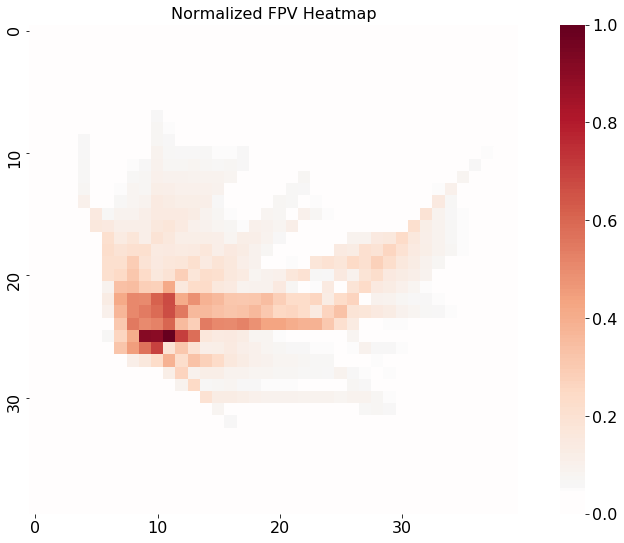

In [214]:
# Global FPV
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
        
# Figure size
plt.figure(figsize = (15, 9)) 

# Font sizes
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 18

# axes
ax = plt.subplot(111)                    
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Title and labels
plt.title("Normalized FPV Heatmap")

# Modify existing map to have white values
cmap = cm.get_cmap('RdBu_r')
lower = plt.cm.seismic(np.ones(100)*0.50)
upper = cmap(np.linspace(1-0.5, 1, 90))
colors = np.vstack((lower, upper))
tmap = matplotlib.colors.LinearSegmentedColormap.from_list('terrain_map_white', colors)
        
        
ax = sns.heatmap(FPVMatrix/np.max(FPVMatrix), center=0.0, xticklabels=10, yticklabels=10, 
                 square=True, cmap=tmap, vmin=0, vmax=np.max(FPVMatrix/np.max(FPVMatrix))) 

In [217]:
PIgnition = np.loadtxt("C:/Users/chile/Desktop/IgnitionProb.csv", delimiter=" ")
PIgnition

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.125, 0.125, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.128, 0.132, 0.132, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.039, 0.039, 0.038],
       [0.   , 0.   , 0.   , ..., 0.024, 0.029, 0.029],
       [0.   , 0.   , 0.   , ..., 0.016, 0.016, 0.019]])

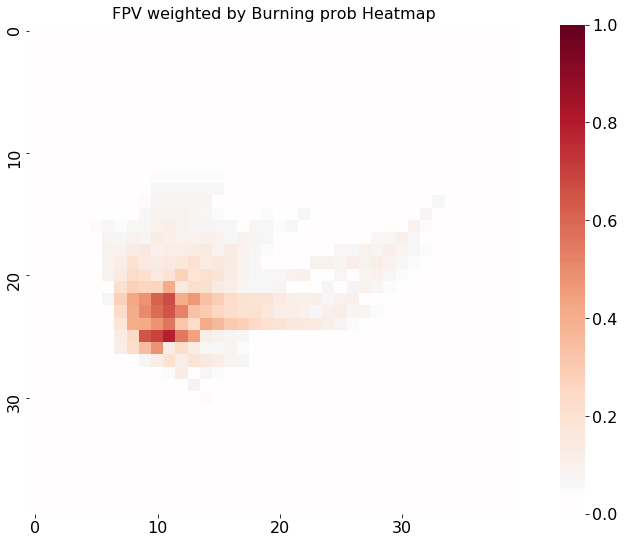

In [227]:
# Global FPV by P Burn
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
        
# Figure size
plt.figure(figsize = (15, 9)) 

# Font sizes
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 18

# axes
ax = plt.subplot(111)                    
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Title and labels
plt.title("FPV weighted by Burning prob Heatmap")

# Modify existing map to have white values
cmap = cm.get_cmap('RdBu_r')
lower = plt.cm.seismic(np.ones(100)*0.50)
upper = cmap(np.linspace(1-0.5, 1, 90))
colors = np.vstack((lower, upper))
tmap = matplotlib.colors.LinearSegmentedColormap.from_list('terrain_map_white', colors)
        
        
ax = sns.heatmap(FPVMatrix/np.max(FPVMatrix) * PIgnition, 
                 center=0.0, xticklabels=10, yticklabels=10, 
                 square=True, cmap=tmap, 
                 vmin=0, vmax=1)

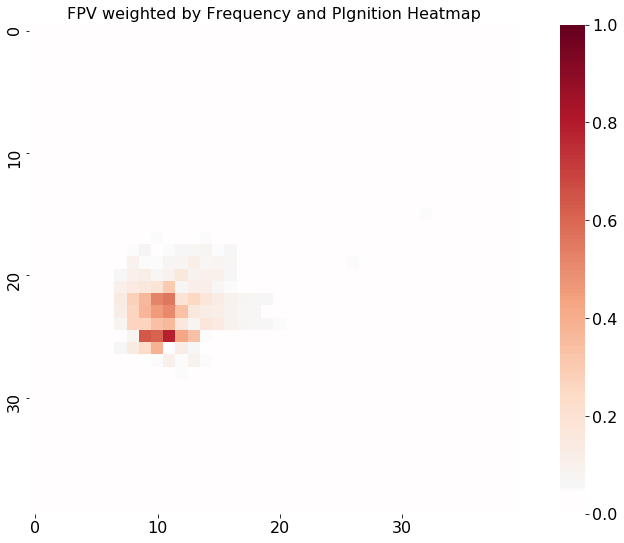

In [229]:
# Global FPV by frequency and PIgnition
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
        
# Figure size
plt.figure(figsize = (15, 9)) 

# Font sizes
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 18

# axes
ax = plt.subplot(111)                    
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Title and labels
plt.title("FPV weighted by Frequency and PIgnition Heatmap")

# Modify existing map to have white values
cmap = cm.get_cmap('RdBu_r')
lower = plt.cm.seismic(np.ones(100)*0.50)
upper = cmap(np.linspace(1-0.5, 1, 90))
colors = np.vstack((lower, upper))
tmap = matplotlib.colors.LinearSegmentedColormap.from_list('terrain_map_white', colors)
        
        
ax = sns.heatmap(FPVMatrix/np.max(FPVMatrix) * OutFireMatrix/np.max(OutFireMatrix) * PIgnition, 
                 center=0.0, xticklabels=10, yticklabels=10, 
                 square=True, cmap=tmap, 
                 vmin=0, vmax=1) 

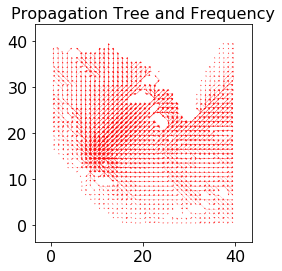

In [132]:
# V0 Frequency
onlyGraph = False

# Agregamos el fuel type atributo (string)
# fuel = dict([(i+1,CellsGrid4[i]) for i in range(len(CellsGrid4))])
# nx.set_node_attributes(G, fuel, 'fuel_type')
# coord_pos = dict() # Diccionario de posiciones cartesianas

# for i in G.nodes:
#     coord_pos[i] = CoordCells[i-1] + 0.5

# Font sizes
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 18

# axes
ax = plt.subplot(111)                    
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

onlyGraph = True
if onlyGraph == False:
    nx.draw_networkx_nodes(G, pos = coord_pos,
                       node_size = 5,
                       nodelist = list(G.nodes),
                       node_shape='s',
                       node_color = Colors)

edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

# Edge = Frequency, width = frequency
#nx.draw_networkx_edges(G, pos = coord_pos, edge_color = weights, edge_cmap=plt.cm.Reds,
#                       width = weights/np.max(weights), arrowsize=1)

# Edge = Frequency, width = frequency
#nx.draw_networkx_edges(G, pos = coord_pos, edge_color = weights/np.max(weights), edge_cmap=plt.cm.Reds,
#                       width = weights/np.max(weights), arrowsize=1)

# Fixed edge color (red), differenc scaled width
nx.draw_networkx_edges(G, pos = coord_pos, edge_color = 'r',
                       width = weights/np.max(weights), arrowsize=3)

# Edge = frequency, fixed width
#nx.draw_networkx_edges(G, pos = coord_pos, edge_color = weights, edge_cmap=plt.cm.Reds,
#                       width = 1.0, arrowsize=2)


#Title
plt.title("Propagation Tree and Frequency")
plt.axis('scaled')
plt.savefig("C:/Users/chile/Desktop/Freq_graph.png", dpi=200, figsize=(200, 200), 
            bbox_inches='tight', transparent=False)

plt.show()
plt.close("all")

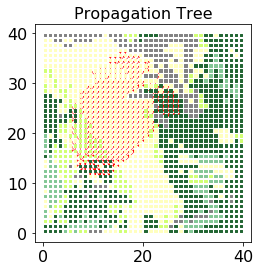

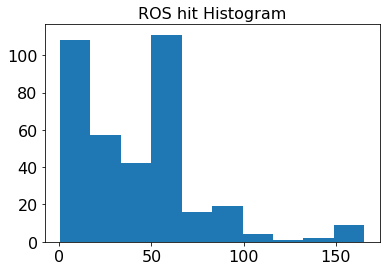

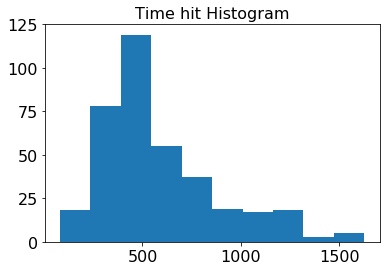

In [130]:
# V1
from operator import itemgetter
import ReadDataPrometheus
from matplotlib.pylab import *
from coord_xy import *
import networkx as nx
import matplotlib.pyplot as plt

print_graph = True
analysis_fpv = False
analysis_degree = True

Folder = 'C:/Users/chile/Documents/GitHub/NewStochSim/Instancias/Dogrib/Sub40x40/' #'#9CellsExample/'  #
FBPlookup = Folder + 'fbp_lookup_table.csv'
ForestFile = Folder + 'Forest.asc'
ignition_file = Folder + 'IgnitionPoints.csv'

FBPDict, ColorsDict = ReadDataPrometheus.Dictionary(FBPlookup)
CellsGrid3, CellsGrid4, Rows, Cols, AdjCells, CoordCells, CellSide = ReadDataPrometheus.ForestGrid(ForestFile,FBPDict)
ignition_point = ReadDataPrometheus.IgnitionPoints(ignition_file)

NCells = Rows * Cols
m = Rows
n = Cols
Colors = []

for i in range(NCells):
    if str(CellsGrid3[i]) not in ColorsDict.keys():
        Colors.append((1.0,1.0,1.0,1.0))
    if str(CellsGrid3[i]) in ColorsDict.keys():
        Colors.append(ColorsDict[str(CellsGrid3[i])])

# Leemos la marca
H = nx.read_edgelist(path = path_messages + "/MessagesFile1.txt",
                     create_using = nx.DiGraph(),
                     nodetype = int,
                     data = [('time',float), ('ros',float)])
# Grid Graph
nodos = range(1, NCells + 1)

# Construimos un objeto DiGraph (grafo dirigido)
#G = nx.DiGraph()
# Agregamos nodos desde lista "nodos"
#G.add_nodes_from(nodos)

# Agregamos el fuel type atributo (string)
fuel = dict([(i+1,CellsGrid4[i]) for i in range(len(CellsGrid4))])
nx.set_node_attributes(G, fuel, 'fuel_type')

ignition_point = ignition_point[1]

coord_pos = dict() # Diccionario de posiciones cartesianas

for i in G.nodes:
    coord_pos[i] = CoordCells[i-1] + 0.5
#     G.node[i]['precio'] = 1
#     G.node[i]['vol'] = 1
#     G.node[i]['cost'] = 0
#     G.node[i]['profit'] = (G.node[i]['precio'] - G.node[i]['cost']) * G.node[i]['vol']
#     if i in H:
#         H.node[i]['profit'] = G.node[i]['profit']


if print_graph == True:
    
#     plt.figure(figsize = (15, 9)) 

    # Font sizes
    plt.rcParams['font.size'] = 16
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams['figure.titlesize'] = 18

    # axes
    ax = plt.subplot(111)                    
    #ax.spines["top"].set_visible(False)  
    #ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 

    # Title and labels
    #plt.title(r'AVG Burned Cells vs Hours')
    #plt.xlabel(r'Hours')
    #plt.ylabel(r'AVG Burned Cells')
    
    # Dimensionamos el eje X e Y
    plt.axis([-1, m, -1, n])

# Imprimimos el grafo
#     plt.figure(1)
#     nx.draw_networkx(G, pos = coord_pos,
#                  node_size = 10,
#                  with_labels = False,
#                  node_color = 'b')
    onlyGraph = False
    if onlyGraph == False:
        nx.draw_networkx_nodes(G, pos = coord_pos,
                           node_size = 5,
                           nodelist = list(G.nodes),
                           node_shape='s',
                           node_color = Colors)

    nx.draw_networkx_edges(H, pos = coord_pos, edge_color = 'r', width = 0.5, arrowsize=4)
    
    #Title
    plt.title("Propagation Tree")
    plt.axis('scaled')

    plt.savefig("C:/Users/chile/Desktop/FPV_graph.png", dpi=200, figsize=(200, 200), 
                bbox_inches='tight', transparent=False)
    

if analysis_fpv == True:
#Agregamos un titulo
    pass

if analysis_degree == True:
    dg_ros_out = sorted(list(H.out_degree(weight = 'ros')), key = itemgetter(1), reverse = True)
    dg_time_out = sorted(list(H.out_degree(weight = 'time')), key = itemgetter(1))

    plt.figure(2)
    dg_ros = dict(H.degree(weight='ros'))
    plt.hist(dg_ros.values())
    plt.title('ROS hit Histogram')

    plt.figure(3)
    dg_time = dict(H.degree(weight='time'))
    plt.hist(dg_time.values())
    plt.title('Time hit Histogram')
    plt.savefig('C:/Users/chile/Desktop/histogram_time.png')

plt.show()
plt.close("all")

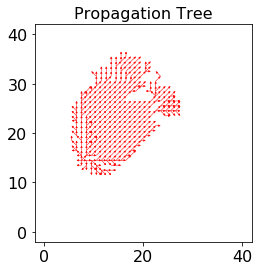

In [131]:
# V2
import itertools
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

#Scatter data
c = 40
r = 40
x = np.linspace(0, c, c+1)
y = np.linspace(0, r, r+1)
pts = itertools.product(x, y)

#Initializing figures
figure()
ax = gca()

#Markers
#ax.scatter(*zip(*pts), marker='o', s=30, color='red', zorder=2)

#Rectangle
edgecolor="None"#'k' if black borders are wanted
lwidth=1.0

rectangle = []
        
# Fill figure
for c in range(0, len(Colors)):
    rectangle.append(plt.Rectangle((CoordCells[c][0], CoordCells[c][1]), 1, 1, 
                                    fc="white", alpha=0.0, ec=edgecolor, linewidth=lwidth))
for i in range(0, len(Colors)):
    ax.add_patch(rectangle[i])

plt.title("Propagation Tree")#,color="white")
plt.axis('scaled')

onlyGraph = True
if onlyGraph == False:
    nx.draw_networkx_nodes(G, pos = coord_pos,
                           node_size = 5,
                           nodelist = list(G.nodes),
                           node_shape='s',
                           node_color = Colors)

nx.draw_networkx_edges(H, pos = coord_pos, edge_color = 'r', width = 0.5, 
                       arrowsize=4, label="ROS messages")

Test=True
if Test: 
    edges = H.edges()
    weights = [H[u][v]['ros'] for u,v in edges]
    times = [H[u][v]['time'] for u,v in edges]
    
    #nx.draw_networkx_edges(H, pos = coord_pos, edge_color = weights, edge_cmap=plt.cm.Reds,
    #                       width = 1.0, arrowsize=2)
    
#     nx.draw_networkx_edges(H, pos = coord_pos, edge_color = times/np.max(times), edge_cmap=plt.cm.Reds_r,
#                            width = 1.0, arrowsize=2)

    #nx.draw_networkx_edges(H, pos = coord_pos, edge_color = weights/np.max(weights), edge_cmap=plt.cm.Reds,
    #                       width = times/np.max(times), arrowsize=2)
    
    #print(weights)

plt.legend()
XCoord = None
YCoord = None

plt.savefig("C:/Users/chile/Desktop/FPV_graphV2.png", dpi=200,  figsize=(200, 200), 
            bbox_inches='tight', transparent=False)

In [14]:
# Basic inputs
Folder = "C:/Users/chile/Desktop/FPVTest_40x40_4Oct"
nSims = 1014

# Grids files (final scars)
a = 0
b = []
statDict = {}
statDF = pd.DataFrame(columns=[["ID", "NonBurned", "Burned", "Harvested"]])

for i in range(nSims):
    GridPath = os.path.join(Folder, "Grids", "Grids"+str(i+1))
    GridFiles = os.listdir(GridPath)
    #print(GridPath, GridFiles)
    if len(GridFiles) > 0: 
        a = pd.read_csv(GridPath +"/"+ GridFiles[-1], delimiter=',', header=None).values
        b.append(a)
        statDict[i] = {"ID": i+1,
                       "NonBurned": len(a[a == 0]),
                       "Burned": len(a[a == 1]), 
                       "Harvested": len(a[a == 2])}
    else:
        if i != 0:
            a = np.zeros([a.shape[0], a.shape[1]]).astype(np.int64)
            b.append(a)
            statDict[i] = {"ID": i+1,
                           "NonBurned": len(a[a == 0]),
                           "Burned": len(a[a == 1]), 
                           "Harvested": len(a[a == 2])}
        else:
            N=40   # To replace with the real values inside the code
            M=40   # To replace with the real values inside the code
            a = np.zeros([N,M]).astype(np.int64)
            b.append(a)
            statDict[i] = {"ID": i+1,
                           "NonBurned": len(a[a == 0]),
                           "Burned": len(a[a == 1]), 
                           "Harvested": len(a[a == 2])}

In [15]:
# Grids files (per hour)  
ah = 0
bh = {}
statDicth = {}
statDFh = pd.DataFrame(columns=[["ID", "NonBurned", "Burned", "Harvested"]])
for i in range(nSims):
    GridPath = os.path.join(Folder, "Grids", "Grids"+str(i+1))
    GridFiles = os.listdir(GridPath)
    if len(GridFiles) > 0:
        for j in range(len(GridFiles)):
            ah = pd.read_csv(GridPath +"/"+ GridFiles[j], delimiter=',', header=None).values
            bh[(i,j)] = ah
            statDicth[(i,j)] = {"ID": i+1,
                               "NonBurned": len(ah[ah == 0]),
                               "Burned": len(ah[ah == 1]), 
                               "Harvested": len(ah[ah == 2]),
                               "Hour": j+1}
    else:
        if i != 0:
            ah = np.zeros([ah.shape[0], ah.shape[1]]).astype(np.int64)
            bh[(i,j)] = ah
            statDicth[(i,j)] = {"ID": i+1,
                                "NonBurned": len(ah[ah == 0]),
                                "Burned": len(ah[ah == 1]), 
                                "Harvested": len(ah[ah == 2]),
                                "Hour": j+1}
        else:
            N=40   # To replace with the real values inside the code
            M=40   # To replace with the real values inside the code
            ah = np.zeros([N,M]).astype(np.int64)
            bh[(i,0)] = ah
            statDicth[(i,0)] = {"ID": i+1,
                                "NonBurned": len(ah[ah == 0]),
                                "Burned": len(ah[ah == 1]), 
                                "Harvested": len(ah[ah == 2]),
                                "Hour": 0+1}

In [16]:
# DF Summary
A = pd.DataFrame(data=statDict, dtype=np.int32)
A = A.T
A = A[["ID", "NonBurned", "Burned", "Harvested"]]
Aux = (A["NonBurned"] + A["Burned"] + A["Harvested"])
A["%NonBurned"], A["%Burned"], A["%Harvested"] = A["NonBurned"] / Aux, A["Burned"] / Aux, A["Harvested"] / Aux
A.to_csv("C:/Users/chile/Desktop/FinalStats.csv", columns=A.columns, index=False, header=True, float_format='%.3f')
A

,ID,NonBurned,Burned,Harvested,%NonBurned,%Burned,%Harvested
0,1,1267,333,0,0.791875,0.208125,0.0
1,2,1304,296,0,0.815000,0.185000,0.0
2,3,1087,513,0,0.679375,0.320625,0.0
3,4,1218,382,0,0.761250,0.238750,0.0
4,5,1226,374,0,0.766250,0.233750,0.0
5,6,1376,224,0,0.860000,0.140000,0.0
6,7,1279,321,0,0.799375,0.200625,0.0
7,8,1127,473,0,0.704375,0.295625,0.0
8,9,1312,288,0,0.820000,0.180000,0.0
9,10,1387,213,0,0.866875,0.133125,0.0


In [17]:
# DF Hour
Ah = pd.DataFrame(data=statDicth, dtype=np.int32)
Ah = Ah.T
Ah[["Hour", "NonBurned", "Burned", "Harvested"]] = Ah[["Hour", "NonBurned", "Burned", "Harvested"]].astype(np.int32)
Ah = Ah[["ID", "Hour", "NonBurned", "Burned", "Harvested"]]
Aux = (Ah["NonBurned"] + Ah["Burned"] + Ah["Harvested"])
Ah["%NonBurned"], Ah["%Burned"], Ah["%Harvested"] = Ah["NonBurned"] / Aux, Ah["Burned"] / Aux, Ah["Harvested"] / Aux
Ah.to_csv("C:/Users/chile/Desktop/HourlyStats.csv", columns=Ah.columns, index=False, header=True, float_format='%.3f')
Ah

ID  Hour  NonBurned  Burned  Harvested  %NonBurned   %Burned  \
0    0     1     1       1596       4          0    0.997500  0.002500   
     1     1     2       1575      25          0    0.984375  0.015625   
     2     1     3       1535      65          0    0.959375  0.040625   
     3     1     4       1461     139          0    0.913125  0.086875   
     4     1     5       1369     231          0    0.855625  0.144375   
     5     1     6       1313     287          0    0.820625  0.179375   
     6     1     7       1267     333          0    0.791875  0.208125   
1    0     2     1       1596       4          0    0.997500  0.002500   
     1     2     2       1583      17          0    0.989375  0.010625   
     2     2     3       1555      45          0    0.971875  0.028125   
     3     2     4       1492     108          0    0.932500  0.067500   
     4     2     5       1437     163          0    0.898125  0.101875   
     5     2     6       1385     215          0    0.865625  0.134375   
     6     2     7       1304     296          0    0.815000  0.185000   
2    0     3     1       1583      17          0    0.989375  0.010625   
     1     3     2       1550      50          0    0.968750  0.031250   
     2     3     3       1501      99          0    0.938125  0.061875   
     3     3     4       1426     174          0    0.891250  0.108750   
     4     3     5       1310     290          0    0.818750  0.181250   
     5     3     6       1179     421          0    0.736875  0.263125   
     6     3     7       1087     513          0    0.679375  0.320625   
3    0     4     1       1585      15          0    0.990625  0.009375   
     1     4     2       1545      55          0    0.965625  0.034375   
     2     4     3       1472     128          0    0.920000  0.080000   
     3     4     4       1395     205          0    0.871875  0.128125   
     4     4     5       1326     274          0    0.828750  0.171250   
     5     4     6       1278     322          0    0.798750  0.201250   
     6     4     7       1218     382          0    0.761250  0.238750   
4    0     5     1       1590      10          0    0.993750  0.006250   
     1     5     2       1562      38          0    0.976250  0.023750   
...      ...   ...        ...     ...        ...         ...       ...   
1009 5  1010     6       1310     290          0    0.818750  0.181250   
     6  1010     7       1267     333          0    0.791875  0.208125   
1010 0  1011     1       1597       3          0    0.998125  0.001875   
     1  1011     2       1584      16          0    0.990000  0.010000   
     2  1011     3       1556      44          0    0.972500  0.027500   
     3  1011     4       1504      96          0    0.940000  0.060000   
     4  1011     5       1442     158          0    0.901250  0.098750   
     5  1011     6       1363     237          0    0.851875  0.148125   
     6  1011     7       1272     328          0    0.795000  0.205000   
1011 0  1012     1       1576      24          0    0.985000  0.015000   
     1  1012     2       1532      68          0    0.957500  0.042500   
     2  1012     3       1429     171          0    0.893125  0.106875   
     3  1012     4       1274     326          0    0.796250  0.203750   
     4  1012     5       1162     438          0    0.726250  0.273750   
     5  1012     6       1074     526          0    0.671250  0.328750   
     6  1012     7       1010     590          0    0.631250  0.368750   
1012 0  1013     1       1593       7          0    0.995625  0.004375   
     1  1013     2       1570      30          0    0.981250  0.018750   
     2  1013     3       1476     124          0    0.922500  0.077500   
     3  1013     4       1360     240          0    0.850000  0.150000   
     4  1013     5       1263     337          0    0.789375  0.210625   
     5  1013     6       1186     414          0    0.741250  0.258750   
     6  1013  

In [ ]:
#statDicth

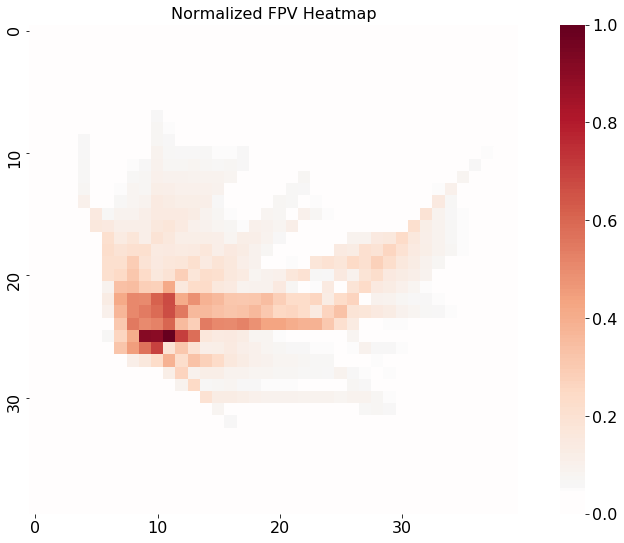

In [133]:
# Global FPV
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
        
# Figure size
plt.figure(figsize = (15, 9)) 

# Font sizes
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 18

# axes
ax = plt.subplot(111)                    
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Title and labels
plt.title("Normalized FPV Heatmap")

# Modify existing map to have white values
cmap = cm.get_cmap('RdBu_r')
lower = plt.cm.seismic(np.ones(100)*0.50)
upper = cmap(np.linspace(1-0.5, 1, 90))
colors = np.vstack((lower, upper))
tmap = matplotlib.colors.LinearSegmentedColormap.from_list('terrain_map_white', colors)
        
        
ax = sns.heatmap(FPVMatrix/np.max(FPVMatrix), center=0.0, xticklabels=10, yticklabels=10, 
                 square=True, cmap=tmap, vmin=0, vmax=np.max(FPVMatrix/np.max(FPVMatrix))) 

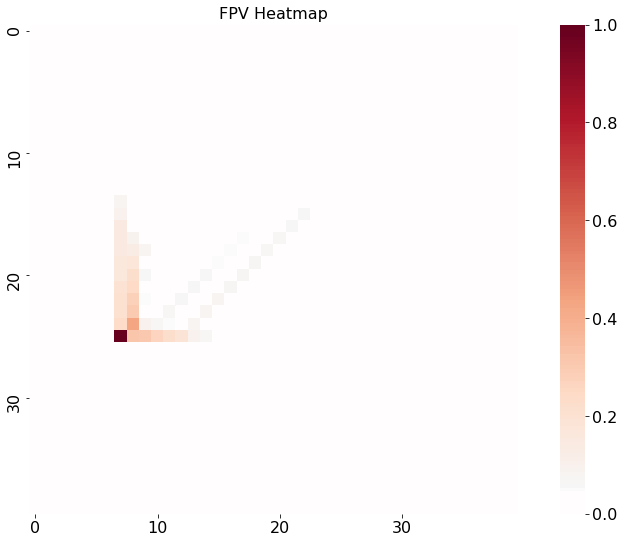

In [134]:
# Individual FPV Example
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
        
# Figure size
plt.figure(figsize = (15, 9)) 

# Font sizes
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 18

# axes
ax = plt.subplot(111)                    
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Title and labels
plt.title("FPV Heatmap")

# Modify existing map to have white values
cmap = cm.get_cmap('RdBu_r')
lower = plt.cm.seismic(np.ones(100)*0.50)
upper = cmap(np.linspace(1-0.5, 1, 90))
colors = np.vstack((lower, upper))
tmap = matplotlib.colors.LinearSegmentedColormap.from_list('terrain_map_white', colors)
        
nsim = 0

ax = sns.heatmap(FPVMatrices[nsim]/np.max(FPVMatrices[nsim]), center=0.0, xticklabels=10, yticklabels=10, 
                 square=True, cmap=tmap, vmin=np.min(FPVMatrices[nsim]/np.max(FPVMatrices[nsim])), 
                 vmax=np.max(FPVMatrices[nsim]/np.max(FPVMatrices[nsim]))) 

In [148]:
G.nodes(True)

NodeDataView({1: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0, 'fuel_type': 'NF'}, 2: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0, 'fuel_type': 'NF'}, 3: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0, 'fuel_type': 'NF'}, 4: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0, 'fuel_type': 'NF'}, 5: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0, 'fuel_type': 'NF'}, 6: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0, 'fuel_type': 'NF'}, 7: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0, 'fuel_type': 'NF'}, 8: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0, 'fuel_type': 'NF'}, 9: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0, 'fuel_type': 'NF'}, 10: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0, 'fuel_type': 'NF'}, 11: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0, 'fuel_type': 'NF'}, 12: {'price': 1, 'vol': 1, 'cost': 0, 'profit': 1, 'fpv': 0, 'fuel_type': 'NF'}, 13: {'price': 1, 'vol':

In [150]:
G.edges(data=True)

OutEdgeDataView([(41, 42, {'weight': 14.0}), (42, 83, {'weight': 8.0}), (53, 13, {'weight': 355.0}), (77, 38, {'weight': 3.0}), (78, 39, {'weight': 1.0}), (79, 40, {'weight': 2.0}), (79, 39, {'weight': 2.0}), (80, 40, {'weight': 4.0}), (81, 41, {'weight': 141.0}), (82, 42, {'weight': 127.0}), (84, 45, {'weight': 157.0}), (87, 46, {'weight': 286.0}), (91, 51, {'weight': 375.0}), (92, 52, {'weight': 373.0}), (92, 51, {'weight': 5.0}), (92, 53, {'weight': 1.0}), (93, 53, {'weight': 363.0}), (93, 54, {'weight': 12.0}), (94, 54, {'weight': 335.0}), (117, 78, {'weight': 5.0}), (117, 77, {'weight': 4.0}), (119, 79, {'weight': 6.0}), (119, 80, {'weight': 19.0}), (120, 80, {'weight': 10.0}), (121, 81, {'weight': 150.0}), (122, 82, {'weight': 146.0}), (123, 83, {'weight': 148.0}), (124, 84, {'weight': 184.0}), (127, 87, {'weight': 254.0}), (128, 88, {'weight': 281.0}), (128, 87, {'weight': 121.0}), (129, 89, {'weight': 184.0}), (129, 88, {'weight': 43.0}), (130, 90, {'weight': 302.0}), (130, 89,

In [152]:
dg_freq_out = sorted(list(G.out_degree(weight = 'weight')), key = itemgetter(1), reverse = True)
print(dg_freq_out)

[(1012, 2148.0), (1010, 2101.0), (1011, 1904.0), (891, 1815.0), (892, 1793.0), (1051, 1729.0), (932, 1681.0), (931, 1679.0), (1013, 1674.0), (1014, 1669.0), (503, 1621.0), (890, 1621.0), (930, 1592.0), (852, 1566.0), (971, 1508.0), (624, 1460.0), (851, 1453.0), (969, 1442.0), (633, 1439.0), (1050, 1406.0), (889, 1404.0), (972, 1401.0), (929, 1396.0), (970, 1373.0), (933, 1367.0), (1049, 1338.0), (850, 1311.0), (810, 1291.0), (463, 1270.0), (813, 1228.0), (774, 1201.0), (594, 1192.0), (894, 1185.0), (625, 1169.0), (1053, 1169.0), (855, 1151.0), (814, 1144.0), (735, 1138.0), (746, 1137.0), (816, 1137.0), (775, 1126.0), (773, 1123.0), (854, 1117.0), (973, 1117.0), (849, 1114.0), (815, 1112.0), (812, 1098.0), (928, 1098.0), (895, 1094.0), (888, 1093.0), (776, 1086.0), (1092, 1069.0), (734, 1068.0), (856, 1065.0), (1094, 1063.0), (1048, 1061.0), (623, 1056.0), (853, 1054.0), (736, 1049.0), (777, 1046.0), (1132, 1043.0), (848, 1042.0), (934, 1034.0), (769, 1033.0), (817, 1031.0), (504, 1029.

{1008: 5, 969: 4, 968: 4, 1009: 3, 1007: 1, 1048: 2, 930: 2, 929: 3, 970: 3, 891: 2, 852: 2, 813: 2, 928: 2, 927: 4, 967: 1, 890: 3, 889: 3, 774: 2, 851: 3, 850: 3, 735: 2, 812: 2, 811: 3, 931: 2, 971: 2, 696: 2, 773: 2, 892: 2, 657: 2, 1010: 4, 1049: 3, 888: 2, 734: 2, 849: 3, 853: 2, 618: 2, 814: 2, 695: 2, 579: 2, 772: 2, 775: 2, 656: 2, 540: 1, 733: 2, 617: 2, 736: 2, 848: 3, 810: 3, 809: 3, 932: 2, 694: 2, 697: 2, 578: 2, 771: 2, 770: 3, 893: 2, 732: 2, 655: 2, 658: 2, 539: 1, 1011: 3, 1051: 4, 1050: 3, 854: 2, 693: 2, 616: 2, 619: 2, 815: 2, 808: 2, 807: 3, 769: 3, 577: 2, 654: 2, 580: 2, 776: 2, 731: 2, 972: 2, 1012: 4, 538: 1, 615: 2, 933: 2, 541: 1, 737: 2, 692: 2, 894: 2, 576: 2, 855: 2, 698: 2, 653: 2, 537: 1, 768: 2, 730: 3, 729: 3, 816: 2, 659: 2, 614: 2, 691: 2, 690: 3, 777: 2, 652: 2, 973: 2, 1013: 4, 1053: 1, 620: 2, 575: 2, 934: 2, 738: 2, 613: 2, 895: 2, 581: 2, 536: 2, 699: 2, 574: 2, 856: 2, 542: 2, 497: 2, 728: 2, 689: 3, 887: 3, 886: 1, 926: 1, 817: 2, 651: 2, 660

(array([108.,  57.,  42., 111.,  16.,  19.,   4.,   1.,   2.,   9.]),
 array([  0.3348281 ,  16.84256267,  33.35029725,  49.85803182,
         66.3657664 ,  82.87350097,  99.38123554, 115.88897012,
        132.39670469, 148.90443927, 165.41217384]),
 <a list of 10 Patch objects>)

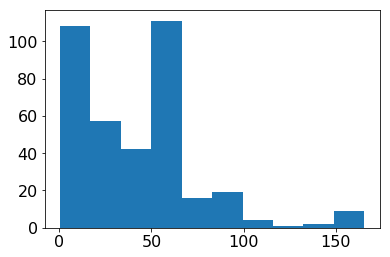

In [160]:
dg_freq = dict(H.degree(weight='weight'))
print(dg_freq)
plt.hist(dg_ros.values())

In [185]:
FD = dict(G.out_degree(weight = 'weight')).values()
# print(FD)
OutFireMatrix = np.reshape(np.fromiter(FD, dtype=np.int32), (40,40))
OutFireMatrix

array([[  0,   0,   0, ...,   0,   0,   0],
       [ 14,   8,   0, ...,   1,   4,   4],
       [141, 127,   0, ...,   0,  25,  10],
       ...,
       [  0,   0,   0, ...,  77,  71,   0],
       [  0,   0,   0, ...,  37,  61,   0],
       [  0,   0,   0, ...,   5,   0,   0]])

In [144]:
cut_weight, partitions = nx.minimum_cut(G, 1008, 1009, capacity="weight")
print ("cut edges capacity " + str(cut_weight))
print ("Set of nodes in the 's' partition: " + str(partitions[0]))
print ("Set of nodes in the 't' partition: " + str(partitions[1]))
edge_cut_list = [] # Computed by listing edges between the 2 partitions
for p1_node in partitions[0]:
    for p2_node in partitions[1]:
        if G.has_edge(p1_node,p2_node):
            edge_cut_list.append((p1_node,p2_node))
print ("Edges of the cut: " + str(edge_cut_list))

cut edges capacity 321.0
Set of nodes in the 's' partition: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21

In [145]:
nx.minimum_edge_cut(G, s=1008, t=1009, flow_func=None)

{(1007, 968),
 (1008, 968),
 (1008, 969),
 (1008, 1009),
 (1008, 1048),
 (1008, 1049)}

In [146]:
nx.minimum_node_cut(G, s=1008, t=1009, flow_func=None)

[]

In [147]:
from networkx.algorithms.connectivity import minimum_st_node_cut
minimum_st_node_cut(G, s=1008, t=1009, flow_func=None, auxiliary=None, residual=None)

[]

# Estimate the FPV function based on:
- Weather file information per instance: multidimensional vector
- Topographic information: Elevation, slope, ps, and saz matrices
- Demographic information: Fuel type matrix ?
- Ignition Point: Scalar

In [ ]:
# Importations
import tensorflow as tf


In [ ]:
# Weather
fileName = "C:/Users/chile/Desktop/FPVTest_40x40_4Oct/Plots/Plots1014/Weather175.csv"
WDF = pd.read_csv(fileName, sep=",")
display(WDF)

# To Matrix (8 x 11)
WMat = WDF.iloc[:, 2:].values
WMat.shape

# To Tensor (8 x 11): hours by features
WTF = tf

In [ ]:
# Elevation, Slope, saz, Forest
Files = ["elevation.asc", "saz.asc", "slope.asc", "Forest.asc"]
DFTopography = {}
MatTopography = {}
cols = 40

for i in Files:
    fileName = "C:/Users/chile/Documents/Github/NewStochSim/Instancias/Dogrib/Sub40x40/"+i
    DFTopography[i] = pd.read_csv(fileName, sep=" ", skiprows=6, names = np.arange(cols))

    # To Matrix 40 x 40
    MatTopography[i] = DFTopography[i].values
    print(i, "shape:", MatTopography[i].shape)
    
# We want a tensor (1600 x 4): Cells x features

In [ ]:
# Ignition Probability
IgnitionMat = np.zeros([40,40])
IPnts = pd.read_csv("C:/Users/chile/Documents/Github/NewStochSim/Instancias/Dogrib/Sub40x40/IgnitionPoints.csv")
for i in IPnts["Ncell"]:
    IgnitionMat[(i-1)//40, i - 40 * ((i-1)//40) - 1 ] = 1

print("Ignition distribution shape:", IgnitionMat.shape)
    
# Checking
np.argmax(IgnitionMat)

# We want a tensor (1600 x 5): Cells x features